In [51]:
# Imports
import warnings
warnings.filterwarnings('ignore')

from itertools import chain
import nltk
import sklearn

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [52]:
from io import open
from conllu import parse, parse_tree, parse_incr

# Data files
train_df = 'hi-ud-train.conllu'
test_df = 'hi-ud-test .conllu'

# Extract Data function
def extract_data(data_file, delimiter = ','):
    corpus = open(data_file, "r", encoding="utf-8").readlines()
    sents = []
    sample = []
    for sent in corpus[1:]:
        processed_sent = sent.strip('\n').split(delimiter)
        if processed_sent == ['', '', '']:
            sents.append(sample)
            sample = []
        else:
            sample.append(processed_sent)
    return sents

# Train
train_sents = extract_data(train_df, ',')

# Test
test_sents = extract_data(test_df, '\t')

**List of Features**

*   Is the first letter of the word capitalised?
*   Is it the first word of the sentence?
*   Is it the last word of the sentence?
*   Is the complete word capitalised?
*   What is the previous and the next word of the word?
*   Is it a number?
*   What are the first four suffixes and prefixes?
*   Does it have a hyphen?

**Justification :**
Features are added for checking if the first letter of a certain word is capitalized or not , if the word is first or last word of a sentence as these can provide information about from which category the word belongs to. Suffices and Prefices were added to give a sense of the tense and word-form. Other small features(case, digit) were also included. Previous and Next words were included to give a sense of the context.Stemmed version of word was tried as well. But it gave negligible improvements in performance due to redundancy with word suffix, prefix-features.



In [53]:
def features(sentence,index):
    return {
        'is_first_capital':int(sentence[index][:1].isupper()),
        'is_first_word': int(index==0),
        'is_last_word':int(index==len(sentence)-1),
        'is_complete_capital': int(sentence[index].upper()==sentence[index]),
        'prev_word':'' if index==0 else sentence[index-1],
        'next_word':'' if index==len(sentence)-1 else sentence[index+1],
        'is_numeric':int(sentence[index].isdigit()),
        'prefix_1':sentence[index][:1],
        'prefix_2': sentence[index][:2],
        'prefix_3':sentence[index][:3],
        'prefix_4':sentence[index][:4],
        'suffix_1':sentence[index][:-1],
        'suffix_2':sentence[index][-2:],
        'suffix_3':sentence[index][-3:],
        'suffix_4':sentence[index][-4:],
        'word_has_hyphen': 1 if '-' in sentence[index] else 0  
         }
def untag(sentence):
    return [token for index, token, postag in sentence]


def prepareData(tagged_sentences):
    X,y=[],[]
    for sent in tagged_sentences:
        X.append([features(untag(sent), index) for index in range(len(sent))])
        y.append([postag for index, token, postag in sent])
    return X,y
X_train,y_train=prepareData(train_sents)
X_test,y_test=prepareData(test_sents)

In [54]:
from sklearn_crfsuite import CRF
crf = CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.01, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [55]:
labels = list(crf.classes_)
print("All POS-labels in training data: ")
print(labels)

All POS-labels in training data: 
['PROPN', 'ADP', 'ADV', 'ADJ', 'NOUN', 'NUM', 'AUX', 'PUNCT', 'PRON', 'VERB', 'CCONJ', 'DET', 'PART', 'COMMA', 'SCONJ', 'X']


In [56]:
# Make predictions and generate metrics
y_train_pred = crf.predict(X_train)
f1 = metrics.flat_f1_score(y_train, y_train_pred, average='weighted', labels=labels)
acc = metrics.flat_accuracy_score(y_train, y_train_pred)

print("Results on Train set: ")
print("Accuracy = {}, F1 score = {}".format(acc, f1))
print("-"*70)

y_pred = crf.predict(X_test)
f1 = metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)
acc = metrics.flat_accuracy_score(y_test, y_pred)

print("Results on Test set: ")
print("Accuracy = {}, F1 score = {}".format(acc, f1))

Results on Train set: 
Accuracy = 0.9981571673028827, F1 score = 0.9981556140952121
----------------------------------------------------------------------
Results on Test set: 
Accuracy = 0.8552631578947368, F1 score = 0.852685712671489


In [57]:
# Print Classification report
# Sort Labels
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

print("Results on Train Set: ")
print(metrics.flat_classification_report(
    y_train, y_train_pred, labels=sorted_labels, digits=3
))

print("-"*70)

print("Results on Test Set: ")
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

Results on Train Set: 
              precision    recall  f1-score   support

           X      1.000     1.000     1.000         2
        PART      1.000     1.000     1.000       163
       CCONJ      0.993     1.000     0.997       150
       SCONJ      1.000     1.000     1.000        61
         ADJ      1.000     1.000     1.000       569
         ADP      0.999     1.000     1.000      1384
         ADV      1.000     0.982     0.991       110
        VERB      1.000     0.986     0.993       639
         DET      0.996     0.996     0.996       229
       COMMA      1.000     1.000     1.000       114
        NOUN      0.999     1.000     1.000      1596
        PRON      0.998     0.998     0.998       430
       PROPN      1.000     0.999     0.999       707
         NUM      1.000     1.000     1.000       152
       PUNCT      1.000     1.000     1.000       563
         AUX      0.988     1.000     0.994       728

    accuracy                          0.998      7597
   

**Hyperparameter Search using RandomizedSearchCV**

In [45]:
# Hyperparameter Search

import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

# Define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.1),
    'c2': scipy.stats.expon(scale=0.1),
}

# Use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# Search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer);
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa929926518>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa929926710>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,


In [46]:
# Extract model with the best Cross-Validation Score in the train-set and corresponding values of the hyperparameters
crf = rs.best_estimator_
print('Best params:', rs.best_params_)
print('Best CV score:', rs.best_score_)
print('Model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

Best params: {'c1': 0.005378247046498694, 'c2': 0.16508957865144072}
Best CV score: 0.8573447062309256
Model size: 0.87M


In [48]:
# Import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

White => 0.8289, Black => 0.8573


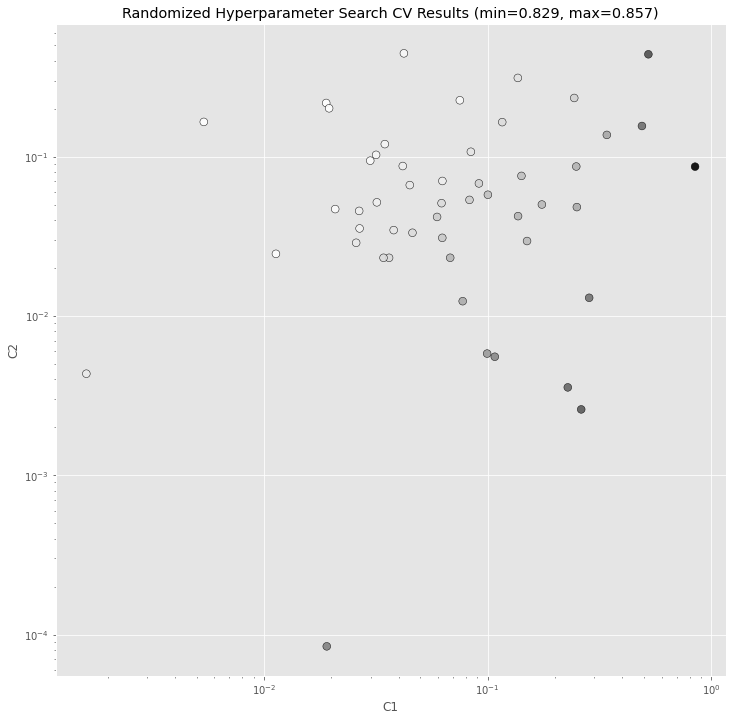

In [49]:
# Plotting parameter values and variation with score
_x = rs.cv_results_["param_c1"]
_y = rs.cv_results_["param_c2"]
_c = rs.cv_results_["mean_test_score"]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0], cmap='gray')

print("White => {:0.4}, Black => {:0.4}".format(min(_c), max(_c)))

In [50]:
# Print Classification report for the model after hyperparameter tuning
# Best Model
crf = rs.best_estimator_

y_train_pred = crf.predict(X_train)
print("Results on Train Set: ")
print(metrics.flat_classification_report(
    y_train, y_train_pred, labels=sorted_labels, digits=3
))

print("-"*70)

y_pred = crf.predict(X_test)
print("Results on Test Set: ")
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

Results on Train Set: 
              precision    recall  f1-score   support

           X      1.000     1.000     1.000         2
        PART      1.000     1.000     1.000       163
       CCONJ      0.993     1.000     0.997       150
       SCONJ      0.984     1.000     0.992        61
         ADJ      1.000     1.000     1.000       569
         ADP      0.998     0.999     0.999      1384
         ADV      0.982     0.982     0.982       110
        VERB      1.000     0.977     0.988       639
         DET      0.996     0.991     0.993       229
       COMMA      1.000     1.000     1.000       114
        NOUN      0.999     0.999     0.999      1596
        PRON      0.995     0.995     0.995       430
       PROPN      1.000     0.996     0.998       707
         NUM      1.000     1.000     1.000       152
       PUNCT      1.000     1.000     1.000       563
         AUX      0.981     1.000     0.990       728

    accuracy                          0.997      7597
   

In [58]:
# Generating Transition Features
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Transition Features in Train-Set")
print("-"*40)
print("Top 10 likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(10))

print("\nTop 10 unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-10:])

Transition Features in Train-Set
----------------------------------------
Top 10 likely transitions:
PROPN  -> PROPN   3.885384
VERB   -> AUX     3.823892
ADJ    -> NOUN    3.489311
NUM    -> NOUN    2.380593
DET    -> NOUN    2.276857
NOUN   -> ADP     2.243182
PROPN  -> ADP     2.210423
NOUN   -> VERB    1.894061
AUX    -> AUX     1.769882
ADJ    -> VERB    1.602079

Top 10 unlikely transitions:
PRON   -> CCONJ   -1.346362
ADP    -> AUX     -1.439019
DET    -> PROPN   -1.452341
ADP    -> COMMA   -1.478561
DET    -> CCONJ   -1.480769
ADJ    -> PRON    -1.594316
CCONJ  -> AUX     -1.762735
CCONJ  -> PART    -1.981091
ADJ    -> ADP     -2.042011
DET    -> ADP     -2.736387


In [59]:
# Generating Transition Features for Test set
crf_dummy = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf_dummy.fit(X_test, y_test)

print("Transition Features in Test-Set")
print("-"*40)
print("Top 10 likely transitions:")
print_transitions(Counter(crf_dummy.transition_features_).most_common(10))

print("\nTop 10 unlikely transitions:")
print_transitions(Counter(crf_dummy.transition_features_).most_common()[-10:])

Transition Features in Test-Set
----------------------------------------
Top 10 likely transitions:
VERB   -> AUX     3.080618
PROPN  -> PROPN   2.564716
ADJ    -> NOUN    2.537360
PROPN  -> ADP     2.130822
AUX    -> AUX     1.960850
NOUN   -> ADP     1.850322
DET    -> NOUN    1.713826
NUM    -> NOUN    1.663300
NOUN   -> VERB    1.465476
NUM    -> NUM     1.209100

Top 10 unlikely transitions:
AUX    -> ADP     -0.793504
DET    -> ADP     -0.834493
ADP    -> CCONJ   -0.854759
VERB   -> PROPN   -0.959755
PROPN  -> ADJ     -1.034799
DET    -> PROPN   -1.110446
AUX    -> VERB    -1.250181
PROPN  -> AUX     -1.327473
ADJ    -> ADP     -1.352714
ADP    -> PUNCT   -1.474916
